**Course website**: http://lagex.github.io/geofisica2

**Note**: This notebook is part of the course "Geofísica 2" of Geology program of the 
[Universidade do Estado do Rio de Janeiro](http://www.uerj.br/). 
All content can be freely used and adapted under the terms of the 
[Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)

Esse documento que você está usando é um [IPython notebook](http://ipython.org/notebook.html). É um documento interativo que mistura texto (como esse), código (como abaixo), e o resultado de executar o código (que pode ser números, texto, figuras, videos, etc).

# Prática 3 - Ondas de superfície

Vamos utilizar as simulações de ondas da biblioteca [Fatiando a Terra](http://www.fatiando.org). Essas simulações utilizam o [método de diferenças finitas](http://en.wikipedia.org/wiki/Finite_difference_method) para calcular soluções da equação da onda.

As tarefas abaixo acompanham as questões que vocês devem responder. Usem as simulações abaixo para te ajudar a responder as perguntas.

## Preparação

Rode a célula abaixo para carregar as componentes necessárias para fazer as simulações. Não se preocupe se aparecer um `:0: FutureWarning: IPython widgets are experimental and may change in the future.` abaixo. Isso é consequência de utilizar tecnologia de ponta.

In [1]:
#%matplotlib inline
from __future__ import division
import numpy as np
from fatiando import utils
from fatiando.seismic.wavefd import Ricker, ElasticPSV, ElasticSH
from fatiando.vis import mpl
import fatiando
import obspy
from obspy.fdsn import Client
from obspy.core.util.geodetics import gps2DistAzimuth, kilometer2degrees
from obspy.taup import TauPyModel
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.html import widgets

:0: FutureWarning: IPython widgets are experimental and may change in the future.
/home/leo/bin/anaconda/lib/python2.7/site-packages/obspy/core/util/base.py:27: UserWarning: Module fatiando was already imported from /home/leo/src/fatiando/fatiando/__init__.pyc, but /home/leo/bin/anaconda/lib/python2.7/site-packages is being added to sys.path
  from pkg_resources import iter_entry_points, load_entry_point


## Sismogramas

In [2]:
client = Client('IRIS')

In [3]:
# Terremoto de Tohoku, 25-04-2015
cat = client.get_events(eventid=3279407)

In [4]:
cat.write('cat', format="QUAKEML")

In [20]:
_ = cat.plot()

In [6]:
event = cat[0]

In [7]:
# Alibek, Turkmenistan
station = client.get_stations(network='II', station='ABKT')[0][0]

In [8]:
station.latitude, station.longitude

(37.9304, 58.1189)

In [9]:
t = obspy.UTCDateTime('2011-03-11 05:46:24')

In [10]:
data = client.get_waveforms('II', 'ABKT', '*', 'LH*', t, t + 1.6*3600)

In [11]:
data.write("TOHOKU-II-ABKT.mseed", format="MSEED")

In [12]:
data = obspy.read('TOHOKU-II-ABKT.mseed')

In [21]:
data.plot()

In [14]:
event_lat = event.origins[0].latitude
event_lon = event.origins[0].longitude
dist, baz, _ = gps2DistAzimuth(station.latitude, station.longitude, 
                               event_lat, event_lon)

In [15]:
print dist, baz

7110569.47547 60.5072157163


In [16]:
st = data.copy()
st.rotate(method='NE->RT', back_azimuth=baz)

In [23]:
st.plot()

In [17]:
st.write("TOHOKU-II-ABKT-rotated.mseed", format="MSEED")

/home/leo/bin/anaconda/lib/python2.7/site-packages/obspy/mseed/core.py:729: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)
/home/leo/bin/anaconda/lib/python2.7/site-packages/obspy/mseed/core.py:764: UserWarning: File will be written with more than one different encodings.
This might have a negative influence on the compatibility with other programs.
  warnings.warn(msg % 'encodings')


In [18]:
model = TauPyModel(model="iasp91")
arrivals = model.get_travel_times(source_depth_in_km=event.origins[0].depth/1000,
                                  distance_in_degree=kilometer2degrees(dist/1000),
                                  phase_list=['P', 'S'])
print(arrivals)

2 arrivals
	P phase arrival at 631.665 seconds
	S phase arrival at 1147.211 seconds


In [19]:
t0 =  obspy.UTCDateTime('2011-03-11 06:10:00')
x = st[1].slice(t0, t0 + 30*60).data
z = st[0].slice(t0, t0 + 30*60).data
d = 10
def plot(i):
    plt.plot(x[i*d:(i+1)*d], z[i*d:(i+1)*d], '-k')
f = plt.figure()
plt.xlim(-5e6, 5e6)
plt.ylim(-5e6, 5e6)
plt.xlabel('x')
plt.ylabel('z')
anim = animation.FuncAnimation(f, plot, interval=100)
plt.show()

## Ondas Love

In [48]:
shape = (200, 700)
spacing = 1000
extent = [0, shape[1]*spacing, shape[0]*spacing, 0]
densidade = np.ones(shape)*2700
velocidade = np.ones(shape)*3800
l1 = 40e3//spacing
densidade[l1:,:] = 3300
velocidade[l1:,:] = 5000

Agora vamos criar o nosso simulador de ondas.

In [38]:
sim1 = ElasticSH(velocidade, densidade, spacing=spacing, taper=0.005)

e colocar uma fonte explosiva na superfície.

In [45]:
f = 0.05
sim1.add_point_source((20e3//spacing, 50e3//spacing), Ricker(5, f, 1/f))

Agora que temos nossa simulação pronta, rode a célcula abaixo para avançar a simulação 400 passos no tempo.

In [46]:
sim1.run(400)

|##################################################|100% Ran 400 iterations in 8.58055 seconds.

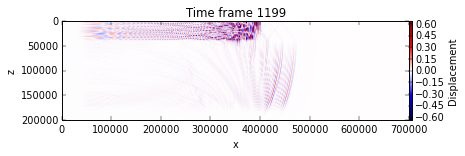

<function fatiando.seismic.wavefd.plot>

In [47]:
sim1.explore(every=20)

In [10]:
sim1.animate(every=20, embed=True, dpi=50, cutoff=0.5)